In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import BinaryJaccardIndex
from utils import custom_replace, calculate_iou
from data import dataset_eval
import pooch

C:\Users\jfrancis\Anaconda3\envs\envAIGOV\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\jfrancis\Anaconda3\envs\envAIGOV\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [4]:
class treenet:
    def __init__(self, model_weights: dict = None, model_type = "multi_spectral"):

        if model_weights is None:
            # RGB
#             if model_type == "RGB":
#                 model_weights = dict(url="doi:10.5281/zenodo.10149636/pytorch_mtloss_partshared_manual.pt",
#                                  known_hash="md5:76fceb351a331d354cbe4d8e3da8a363")
            
            # 12 band, RGB + NIR + Sentinel 2    
            if model_type == "multi_spectral":
                model_weights = dict(url="https://zenodo.org/records/10149637/files/pytorch_mtloss_partshared_manual_allbands.pt",
                                  known_hash="md5:450007e5233c08f595d549b873a9ff12")
                pooch.retrieve(url=model_weights['url'], known_hash= model_weights['known_hash'])

        # ---- DOWNLOAD
        self.model_weights = pooch.retrieve(url=model_weights['url'], known_hash=model_weights['known_hash'])


        # ---- LOAD MODEL        
        def defineUNetModel_partiallyshared():
            def double_conv0(in_channels, out_channels):
                return nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 3, padding="same"),
                    nn.InstanceNorm2d(out_channels),
                    nn.LeakyReLU(inplace=True),
                    nn.Dropout(p=0.1),
                    nn.Conv2d(out_channels, out_channels, 3, padding="same"),
                    nn.InstanceNorm2d(out_channels),
                    nn.LeakyReLU(inplace=True)
                )  
            def double_conv(in_channels, out_channels):
                return nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 3, padding=1),
                    nn.LeakyReLU(inplace=True),
                    nn.Dropout(p=0.1),
                    nn.Conv2d(out_channels, out_channels, 3, padding=1),
                    nn.LeakyReLU(inplace=True)
                )
            
            class UNet(nn.Module):
                def __init__(self_unet):
                    super().__init__()
        
                    self_unet.dconv_down1 = double_conv0(14, 32)
                    self_unet.dconv_down2 = double_conv(32, 64)
                    self_unet.dconv_down3 = double_conv(64, 128)
                    self_unet.dconv_down4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, padding=1),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(p=0.2),
                        nn.Conv2d(256, 256, 3, padding=1),
                        nn.LeakyReLU(inplace=True))
        
                    self_unet.maxpool = nn.MaxPool2d(2)
                    self_unet.maxpool3 = nn.MaxPool2d(3)
                    
                    self_unet.upsample1a = nn.ConvTranspose2d(256, 128, 3, stride=3, padding=0)
                    self_unet.upsample1b = nn.ConvTranspose2d(256, 128, 3, stride=3, padding=0)
                    self_unet.upsample1c = nn.ConvTranspose2d(256, 128, 3, stride=3, padding=0)
                    
                    self_unet.upsample2a = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
                    self_unet.upsample2b = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
                    self_unet.upsample2c = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
                    
                    self_unet.upsample3a = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=0)
                    self_unet.upsample3b = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=0)
                    self_unet.upsample3c = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=0)
                    
                    
                    self_unet.dconv_up3a = double_conv(128+128, 128)
                    self_unet.dconv_up3b = double_conv(128+128, 128)
                    self_unet.dconv_up3c = double_conv(128+128, 128)
                    
                    self_unet.dconv_up2a = double_conv(64 + 64, 64)
                    self_unet.dconv_up2b = double_conv(64 + 64, 64)
                    self_unet.dconv_up2c = double_conv(64 + 64, 64)
                    
                    self_unet.dconv_up1a = double_conv(32 + 32, 32)
                    self_unet.dconv_up1b = double_conv(32 + 32, 32)
                    self_unet.dconv_up1c = double_conv(32 + 32, 32)
        
                    self_unet.conv_lasta = nn.Conv2d(32, 1, 1)
                    self_unet.conv_lastb = nn.Conv2d(32, 1, 1)
                    self_unet.conv_lastc = nn.Conv2d(32, 1, 1)
                            
                    self_unet.linear = nn.MaxPool2d(2)
                    self_unet.sigmoid = nn.Sigmoid()
                def forward(self_unet, x):
                    conv1 = self_unet.dconv_down1(x)
                    x = self_unet.maxpool(conv1)
        
                    conv2 = self_unet.dconv_down2(x)
                    x = self_unet.maxpool(conv2)
        
                    conv3 = self_unet.dconv_down3(x)
                    x = self_unet.maxpool3(conv3)
        
                    encoder_end = self_unet.dconv_down4(x)
        
                    
                    # Tree Height
                    x1 = self_unet.upsample1a(encoder_end)
                    x1 = torch.cat([x1, conv3], dim=1)
                    x1 = self_unet.dconv_up3a(x1)
        
                    x1 = self_unet.upsample2a(x1)
                    x1 = torch.cat([x1, conv2], dim=1)
                    x1 = self_unet.dconv_up2a(x1)
        
                    x1 = self_unet.upsample3a(x1)
                    x1 = torch.cat([x1, conv1], dim=1)
                    x1 = self_unet.dconv_up1a(x1)
                    out_tree_height = self_unet.conv_lasta(x1) # looks like i don't need any additional activation here for linear
        
                    # Tree Mask
                    x2 = self_unet.upsample1b(encoder_end)
                    x2 = torch.cat([x2, conv3], dim=1)
                    x2 = self_unet.dconv_up3b(x2)
        
                    x2 = self_unet.upsample2b(x2)
                    x2 = torch.cat([x2, conv2], dim=1)
                    x2 = self_unet.dconv_up2b(x2)
        
                    x2 = self_unet.upsample3b(x2)
                    x2 = torch.cat([x2, conv1], dim=1)
                    x2 = self_unet.dconv_up1b(x2)
                    out_tree_mask = self_unet.sigmoid(self_unet.conv_lastb(x2))            
             
                    
                    return [out_tree_height, out_tree_mask]
            model=UNet()
            return model
        
        treenet = defineUNetModel_partiallyshared().to(device)   
         
        # Load in the model weights
        treenet.load_state_dict(torch.load(self.model_weights, map_location=torch.device('cpu')))
        
        #initialise the model in evaluation mode
        self.model = treenet
        #self.model.eval()

        
        
#     def get_sample(self, ds, idx):
#         im_target = ds.sel(concat_dim=idx)
#         image = im_target['raster'].values
#         iml = im_target.image_length.values
#         imw = im_target.image_width.values
#         return idx, image[0:iml, 0:imw, :]

    def show_output(self, obs, preds_m, preds_h):

        # not sure if i want a way to display a full batch
#         if xarray:
#             plt.figure(figsize=(20, 20))
#             columns = 4
#             samples = [self.get_sample(obs, idx=i) for i in range(17)]
#             for i, image in enumerate(samples):
#                 plt.subplot(int(len(samples) / columns + 1), columns, i + 1)
#                 plt.imshow(image[1])
#                 plt.axis('off')
#                 plt.title("Prediction", fontsize='xx-large')

        # Original Image
        ax = plt.subplot(1,3, 1)
        plt.imshow(np.transpose(obs.squeeze()[0:3], axes=[1,2,0])/255)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
        
        # Predicted Tree Mask
        ax = plt.subplot(1,3, 2)
        plt.imshow(preds_m.squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
        # Predicted Tree Height
        ax = plt.subplot(1,3, 3)
        plt.imshow(preds_h.squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
            
        
        plt.show()

    def predict_batch(self, image: np.ndarray, batch_size: int):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        my_dataloader = DataLoader(my_dataset, batch_size=16,shuffle=False)

        height_mae = []
        mask_iou = []
        with torch.inference_mode():
            for i_batch, sample_batched in enumerate(my_dataloader):
                X,Y= sample_batched
                X= X.to(device)
                
                Y[0]=Y[0].to(device) 
                Y[1]=Y[1].to(device)
                
                X = Variable(X.float().cuda())
                Y[0] = Variable(Y[0].float().cuda())
                Y[1] = Variable(Y[1].float().cuda())

                # Forward pass
                pred_tree_height, pred_tree_mask = self.model(X)
        
                # mask predicted tree height with the tree mask
                pred_tree_mask = custom_replace(pred_tree_mask, .4) # .4+ probability= tree
                pred_tree_height[pred_tree_height  < 0 ] = 0 # no negative tree heights
                pred_tree_height = torch.squeeze(pred_tree_height)*torch.squeeze(pred_tree_mask) #0s get rid of non tree pixels

                # If ground truth data can calculate some metrics
                actual_tree_height= Y[0]*torch.squeeze(pred_tree_mask)
                height_mae.append(mean_absolute_error(pred_tree_height,actual_tree_height).item())
                mask_iou.append(iou_score(torch.squeeze(pred_tree_mask),Y[1].type(torch.LongTensor).to(device)))
        

        self.show_output(image,pred_tree_mask, pred_tree_height)#,xarray=True)

        return pred_tree_mask, pred_tree_height

    def predict(self, np_image: np.ndarray) -> np.ndarray:
        # want shape (1,14,240,240)
        
        # Ensure no very small values (might have been an artifact of the original data)
        np_image[np_image  < .0000001] = 0
        
        # normalize values of the input data to 0,1
        np_image = np_image/np_image.max(axis=(1),keepdims=True)
        
        np_image = torch.from_numpy(np_image)
        np_image = np_image.to(device)
        np_image = Variable(np_image.float())
        #np_image = Variable(np_image.float().cuda())
        
        with torch.inference_mode():
            pred_tree_height, pred_tree_mask = self.model(np_image)
            pred_tree_mask = custom_replace(pred_tree_mask, .4) # .4+ probability= tree
            pred_tree_height[pred_tree_height  < 0 ] = 0 # no negative tree heights
            pred_tree_height = torch.squeeze(pred_tree_height)*torch.squeeze(pred_tree_mask) #0s get rid of non tree pixels

        self.show_output(image,pred_tree_mask, pred_tree_height)

        return pred_tree_mask, pred_tree_height


if __name__ == "__main__":
    pass

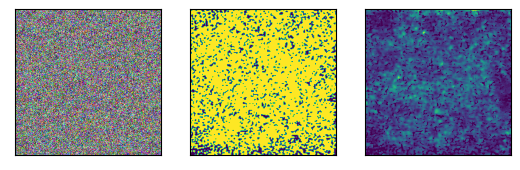

In [5]:
# test numpy array
# load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = treenet(model_type = "multi_spectral")

## create RGB image
image = np.random.randint(255, size=(1, 14, 240, 240), dtype=np.uint8)

##predict
y = model.predict(np_image=image)

In [ ]:
# test batch
##predict
#image_batch = 
y = model.predict_batch(image_batch, batch_size=16)